## Directory settings

In [1]:
# ======================================================
# Directory settings
# ======================================================
import os
import pandas as pd

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedir(OUTPUT_DIR)
    
TEST_PATH = '../input/ranzcr-clip-catheter-line-classification/test'

## CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    num_workers=4
    model_name='resnet200d_320'
    size=640
    batch_size=128
    seed=416
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    submit = (len(pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')) != 3582)
#     submit = True

## Library

In [3]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:, i], y_pred[:, i])
        scores.append(score)
    avg_score = np.mean(scores, axis=0)
    return avg_score, scores

def get_result(result_df):
    labels = result_df[CFG.target_cols].values
    preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f} Scores: {np.round(scores, decimals=4)}')
    
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')
    
def init_logger(log_file=OUTPUT_DIR+'inference.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

## Data Loading

In [5]:
oof_df = pd.read_csv('../input/training-resnet200d-step3-ver-41/oof_df.csv')
for fold in CFG.trn_fold:
    fold_oof_df = oof_df[oof_df['fold']==fold].reset_index(drop=True)
    LOGGER.info(f'========== fold: {fold} result ===========')
    get_result(fold_oof_df)

========== fold: 0 result ===========
Score: 0.9673 Scores: [0.9842 0.9779 0.9941 0.9284 0.9637 0.9898 0.9925 0.9485 0.9109 0.95
 0.9999]


In [6]:
if CFG.debug:
    test = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv', nrows=10)
else:
    test = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')

print(test.shape)
test.head()

(3582, 12)


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0,0,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0,0,0,0,0,0,0,0,0,0,0


## Dataset

In [7]:
# ===================================================
# Dataset
# ===================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}.jpg'
        image = cv2.imread(file_path)
#         mask = image[:, :, 0] > 0
#         image = image[np.ix_(mask.any(axis=1), mask.any(axis=0))]
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

## Transform

In [8]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

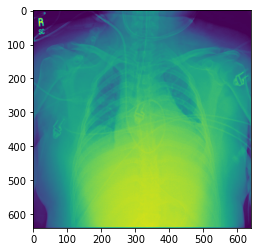

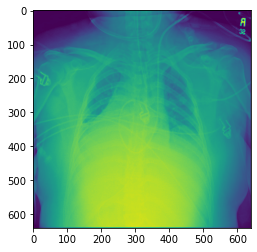

In [9]:
train_dataset = TestDataset(test, transform=get_transforms(data='valid'))

for i in range(1):
    image = train_dataset[i]
    plt.imshow(image[0])
    plt.show()
    plt.imshow(image[0].flip(-1))
    plt.show()

## MODEL

In [10]:
class PAM_Module(nn.Module):
    """ Position attention module"""
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out
    
class CAM_Module(nn.Module):
    """ Channel attention module"""
    def __init__(self, in_dim):
        super(CAM_Module, self).__init__()
        self.chanel_in = in_dim
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention = torch.softmax(energy_new, dim=-1)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out
    
class CBAM(nn.Module):
    def __init__(self, in_channels):
        # def __init__(self):
        super(CBAM, self).__init__()
        inter_channels = in_channels // 4
        self.conv1_c = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU(inplace=True))
        
        self.conv1_s = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU(inplace=True))

        self.channel_gate = CAM_Module(inter_channels)
        self.spatial_gate = PAM_Module(inter_channels)
        
        self.conv2_c = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU(inplace=True))
        self.conv2_a = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU(inplace=True))
        
    def forward(self, x):
        feat1 = self.conv1_c(x)
        chnl_att = self.channel_gate(feat1)
        chnl_att = self.conv2_c(chnl_att)

        feat2 = self.conv1_s(x)
        spat_att = self.spatial_gate(feat2)
        spat_att = self.conv2_a(spat_att)

        x_out = chnl_att + spat_att

        return x_out

In [11]:
# ====================================================
# MODEL
# ====================================================
class CustomResNet200D(nn.Module):
    def __init__(self, model_name='resnet200d_320', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        if pretrained:
            pretrained_path = '../input/resnet200d-pretrained-weight/resnet200d_ra2-bdba9bf9.pth'
            self.model.load_state_dict(torch.load(pretrained_path))
            print(f'load {model_name} pretrained model')
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_features, CFG.target_size)

        
    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return output
    
class CustomResNet200D_WLF(nn.Module):
    def __init__(self, model_name='resnet200d_320', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        n_features  = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)
        
        if pretrained:
            pretrained_path = '../input/startingpointschestx/resnet200d_320_chestx.pth'
#             self.model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu'))['model'])
            
            checkpoint = torch.load(pretrained_path, map_location='cpu')['model']
            for key in list(checkpoint.keys()):
                if 'model.' in key:
                    checkpoint[key.replace('model.', '')] = checkpoint[key]
                    del checkpoint[key]
            self.model.load_state_dict(checkpoint) 
            
            print(f'load {model_name} pretrained model')
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Linear(n_features, CFG.target_size)
        
        self.local_fe = CBAM(n_features)
        self.classifier = nn.Sequential(nn.Linear(n_features + n_features, n_features), 
                                        nn.BatchNorm1d(n_features),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(n_features, CFG.target_size))
    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        
        global_features = self.pooling(features).view(bs, -1)
        
        local_features = self.local_fe(features)
        local_features = torch.sum(local_features, dim=[2, 3])  # ここ、どうしてsum？GAPではない？
        
        all_features = torch.cat([global_features, local_features], dim=1)
        output = self.classifier(all_features)
        
        return output

## Helper finctions

In [12]:
# ====================================================
# Helper functions
# ====================================================
def inference(models, test_loader, device):
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    
    probs = []
    for i, images in tk0:
        images = images.to(device)
        avg_preds = []
        for model in models:
            with torch.no_grad():
                y_preds1 = model(images)
                y_preds2 = model(images.flip(-1))
            y_preds = (y_preds1.sigmoid().to('cpu').numpy() + y_preds2.sigmoid().to('cpu').numpy()) / 2
            avg_preds.append(y_preds)
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

## inference

In [13]:
%%time

models = []

model = CustomResNet200D_WLF(CFG.model_name, pretrained=False)
model_path = '../input/training-resnet200d-step3-ver-41/resnet200d_320_fold0_best_loss.pth'
model.load_state_dict(torch.load(model_path)['model'])
model.eval()

models.append(model.to(device))

# model = CustomResNet200D_WLF(CFG.model_name, pretrained=False)
# model_path = '../input/007-training-resnext-step3-data/resnet200d_320_fold1_best_score.pth'
# model.load_state_dict(torch.load(model_path)['model'])
# model.eval()

# models.append(model.to(device))

CPU times: user 3.19 s, sys: 1.37 s, total: 4.56 s
Wall time: 13 s


In [14]:
if CFG.submit:
    test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
    test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    predictions = inference(models, test_loader, device)
    # submission
    test[CFG.target_cols] = predictions
    test[['StudyInstanceUID'] + CFG.target_cols].to_csv(OUTPUT_DIR+'submission.csv', index=False)
    test.head()
    
else:
    pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv').to_csv('submission.csv', index=False)